In [1]:
import os
import shutil
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from invert import invert_ebb, load_source_time_series
from simulate import run_dipole_simulation
from matplotlib import colors
from scipy.interpolate import interp1d
import elephant
import neo
import quantities as pq

In [2]:
def csd_calc(signal, thickness, sfreq):
    """
    signal - contact x time
    thickness - overall in mm
    sampling rate - in Hz
    """
    sig = neo.core.AnalogSignal(
        signal.T, units="T", sampling_rate=sfreq*pq.Hz
    )
    th = pq.Quantity(np.linspace(0, thickness, num=11).reshape(-1,1)) * pq.mm
    csd_est = elephant.current_source_density.estimate_csd(
        sig, th,
        method = "StandardCSD"
    )
    return csd_est.as_array().T

def csd_smooth(csd, layers=11, kind="cubic"):
    layers, time = csd.shape
    smoothed = []
    x = np.linspace(0, 1, num=layers)
    xs = np.linspace(0, 1, num=500)
    for t in range(time):
        fx = interp1d(x, csd[:, t], kind=kind)
        ys = fx(xs)
        smoothed.append(ys)
    smoothed = np.array(smoothed).T
    return smoothed
  
# visualisation
def plot_spaced_signal(signal, times, ax):
    v_contacts = signal.shape[0]
    cm = plt.colormaps["rainbow"]
    cm_l = cm(np.linspace(0,1, num=v_contacts))[:,:3]
    max_amp = np.abs(signal).max()
    max_amp = max_amp + max_amp*0.05
    spacing = np.linspace(0, max_amp * v_contacts, num=v_contacts)
    vis_signal = signal + spacing.reshape(-1,1)
    for ix, vs in enumerate(vis_signal):
        ax.plot(times, vs, lw=1, c=cm_l[ix])
    ax.set_yticks(spacing)
    ax.set_yticklabels(np.arange(1,v_contacts+1)[::-1])
    ax.set_ylim(spacing[0] - max_amp, spacing[-1] + max_amp)
    
 
    
def plot_csd(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True, cmap="RdBu_r", vmin_vmax=None, return_details=False):
    layer_labels = ["I", "II", "III", "IV", "V", "VI"]
#     with open(bb_path, "r") as fp:
#         bb = json.load(fp)
#     bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
#     bb_mean = [np.mean(i) for i in bb]
#     bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    if vmin_vmax == None:
        divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    elif vmin_vmax == "norm":
        divnorm = colors.Normalize()
    else:
        divnorm = colors.TwoSlopeNorm(vmin=vmin_vmax[0], vcenter=0, vmax=vmin_vmax[1])
    extent = [times[0], times[-1], 0, 1]
    csd_imshow = ax.imshow(
        smooth_csd, norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap=cmap, interpolation="none"
    )
    ax.set_ylim(1,0)
    ax.set_yticks(np.linspace(0,1, 11))
    ax.set_yticklabels(np.arange(1,12))
    layers_params = []
#     for l_ix, th in enumerate(np.cumsum(bb_mean)):
#         ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
#         ax.annotate(layer_labels[l_ix],[times[0]+0.06, th-0.01], size=15, ha='left')
#         layers_params.append([th, layer_labels[l_ix]])
    if cb:
        clbr=plt.colorbar(csd_imshow, ax=ax)
        clbr.set_label('CSD')
    plt.tight_layout()
    if return_details:
        return layers_params, csd_imshow

In [18]:
# Where to put simulated data
tmp_dir='/scratch/bonaiuto/simulated_data/csd'

# Subject information for data to base simulations on
subj_id='sub-104'
ses_id='ses-01'
# Fiducial coil coordinates
nas=[0.9662503311032098, 108.83514306876269, 1.6712361927090313]
lpa=[-74.28671169006893, 20.15061014698176, -29.849056272705948]
rpa=[76.02110531729883, 18.9467849625573, -25.779407159603114]
bb_path='./layer_fsaverage'

# Native space MRI to use for coregistration
mri_fname = os.path.join('./test_data','spm', subj_id, 's2023-02-28_13-33-133958-00001-00224-1.nii')
# Mesh to use for forward model
multilayer_mesh_fname = os.path.join('./test_output', subj_id, 'multilayer.11.ds.link_vector.gii')

# Get name of each mesh that makes up the layers of the multilayer mesh
n_layers=11
layers = np.linspace(1, 0, n_layers)
layer_fnames = []
for l, layer in enumerate(layers):
    if layer == 1:
        layer_fnames.append(os.path.join('./test_output', subj_id, 'pial.ds.link_vector.gii'))
    elif layer > 0 and layer < 1:
        layer_name = '{:.3f}'.format(layer)
        layer_fnames.append(os.path.join('./test_output', subj_id, f'{layer_name}.ds.link_vector.gii'))        
    elif layer == 0:
        layer_fnames.append(os.path.join('./test_output', subj_id, 'white.ds.link_vector.gii'))
    
# Load multilayer mesh and compute the number of vertices per layer
mesh=nib.load(multilayer_mesh_fname)
verts_per_surf=mesh.darrays[0].data.shape[0]/n_layers

# Data file to base simulations on
data_file=os.path.join('./test_data', 'processed', subj_id, ses_id, 'spm/pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat')
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Copy data files to tmp directory
shutil.copy(os.path.join(data_path, f'{data_base}.mat'), os.path.join(tmp_dir, f'{data_base}.mat'))
shutil.copy(os.path.join(data_path, f'{data_base}.dat'), os.path.join(tmp_dir, f'{data_base}.dat'))

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

In [ ]:
# Invert the subject's data. This step only has to be done once - this is just to compute the forward model
# that will be used in the simulations

# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size=5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

[_,_]=invert_ebb(nas, lpa, rpa, mri_fname, multilayer_mesh_fname, base_fname, n_layers, patch_size=patch_size, 
                 n_temp_modes=n_temp_modes)

Text(0, 0.5, 'Amplitude (nAm)')

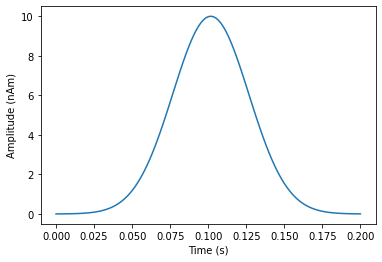

In [21]:
# Vertex to simulate activity at
sim_vertex=420
# Strength of simulated activity (nAm)
dipole_moment=10
# Size of simulated patch of activity (mm)
sim_patch_size=5
# SNR of simulated data (dB)
SNR=-5
# Temporal width of the simulated Gaussian
signal_width=.025 # 25ms

# Generate 200ms of a Gaussian at a sampling rate of 600Hz (to match the data file)
time=np.linspace(0,.2,121)
zero_time=time[int((len(time)-1)/2+1)]
sim_signal=np.exp(-((time-zero_time)**2)/(2*signal_width**2))
plt.plot(time,dipole_moment*sim_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

layer_verts=[l*int(verts_per_surf)+sim_vertex for l in range(n_layers)]
layer_coords=mesh.darrays[0].data[layer_verts,:]
layer_dists=np.sqrt(np.sum(np.diff(layer_coords,axis=0)**2,axis=1))
print(layer_dists)

In [10]:
pial_vertex=sim_vertex
white_vertex=(n_layers-1)*int(verts_per_surf)+sim_vertex

pial_unit_norm=mesh.darrays[2].data[pial_vertex,:]
white_unit_norm=-1*mesh.darrays[2].data[white_vertex,:]

In [9]:
prefix=f'sim_{sim_vertex}_superficial.'
pial_sim_fname=run_dipole_simulation(base_fname, prefix, pial_vertex, sim_signal, pial_unit_norm, dipole_moment, 
                                     sim_patch_size, SNR)    

In [11]:
[_,_]=invert_ebb(nas, lpa, rpa, mri_fname, mesh_fname, pial_sim_fname, n_layers, patch_size=patch_size, 
                 n_temp_modes=n_temp_modes)

Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing


In [18]:
layer_ts=load_source_time_series(pial_sim_fname, vertices=layer_verts)
layer_ts=np.array(layer_ts)
csd=csd_calc(layer_ts,np.mean(layer_dists),600)
smooth_csd=csd_smooth(csd)

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


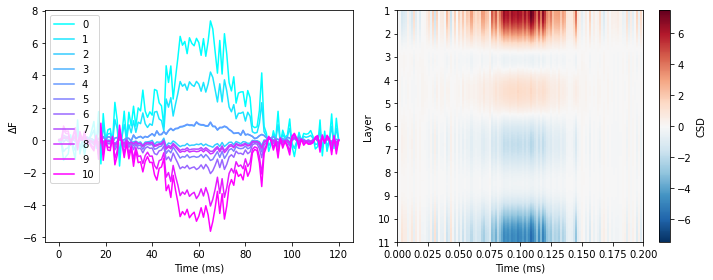

In [21]:
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for l in range(n_layers):
    plt.plot(csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')
ax=plt.subplot(1,2,2)
plot_csd(smooth_csd, [sim_vertex], bb_path, time, ax)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()

In [29]:
prefix=f'sim_{sim_vertex}_deep.'
white_sim_fname=run_dipole_simulation(base_fname, prefix, white_vertex, sim_signal, white_unit_norm, 
                                      dipole_moment, sim_patch_size, SNR)    

In [30]:
[_,_]=invert_ebb(nas, lpa, rpa, mri_fname, mesh_fname, white_sim_fname, n_layers, patch_size=patch_size, 
                 n_temp_modes=n_temp_modes)

Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing


In [31]:
layer_ts=load_source_time_series(white_sim_fname, vertices=layer_verts)
layer_ts=np.array(layer_ts)
csd=csd_calc(layer_ts,np.mean(layer_dists),600)
smooth_csd=csd_smooth(csd)

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


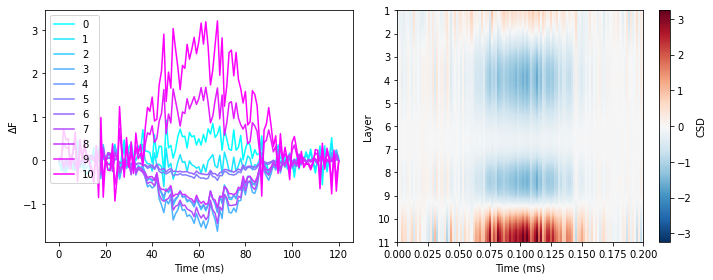

In [32]:
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for l in range(n_layers):
    plt.plot(csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')
ax=plt.subplot(1,2,2)
plot_csd(smooth_csd, [sim_vertex], bb_path, time, ax)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()

Simulating in layer 0
Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
Simulating in layer 1
Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
Simulating in layer 2
Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
Simulating in layer 3
Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
Simulating in layer 4
Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is a

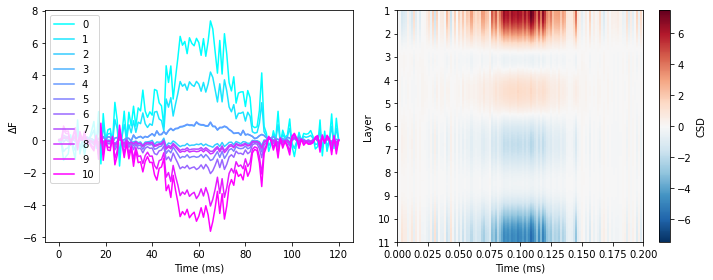

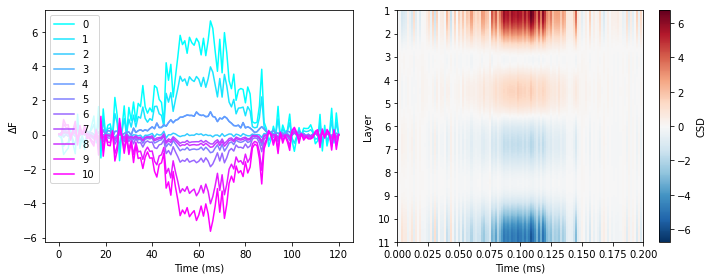

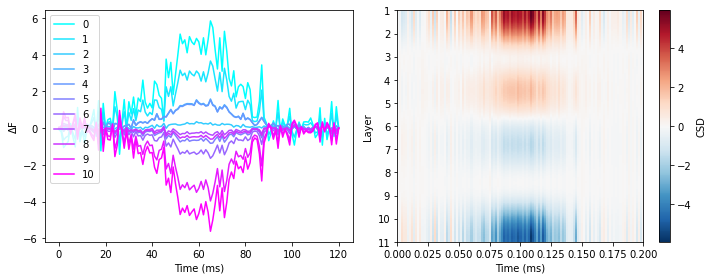

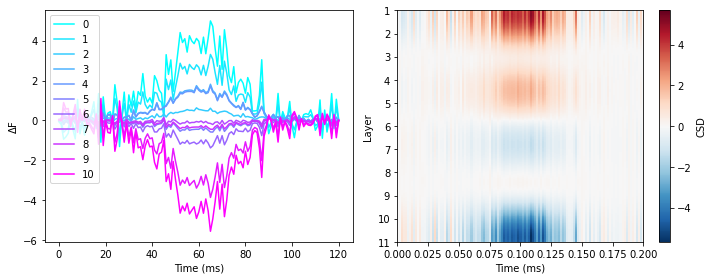

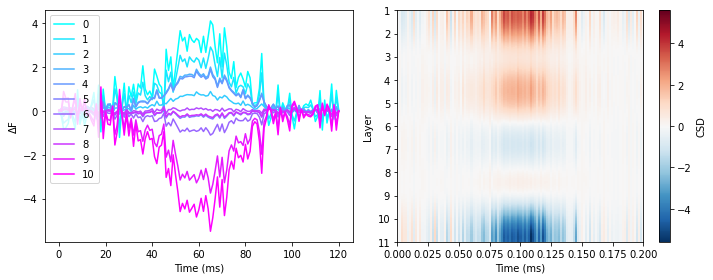

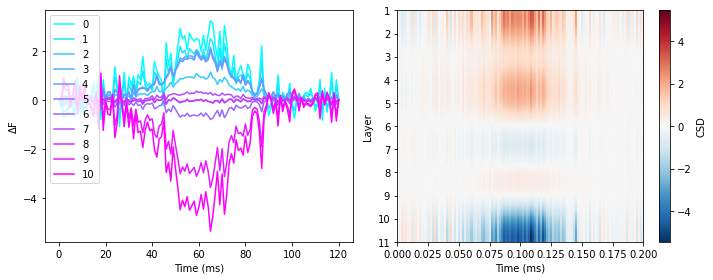

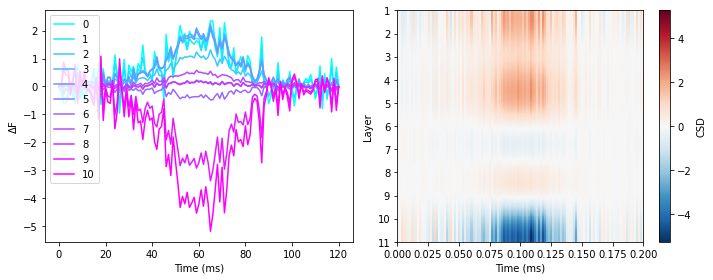

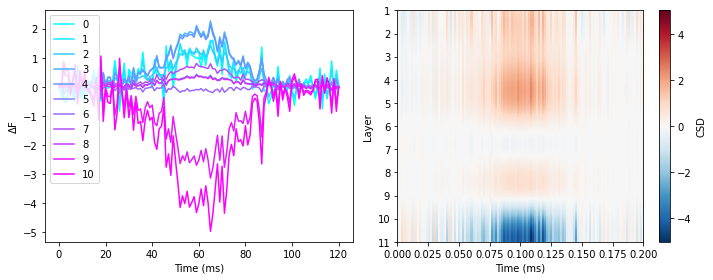

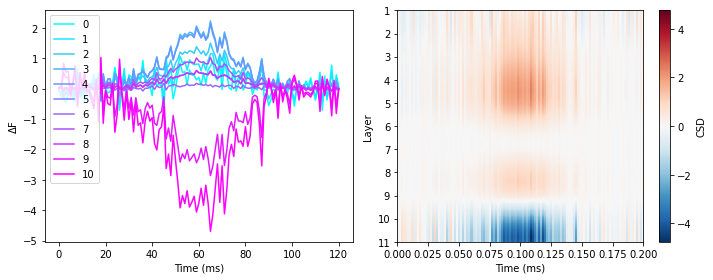

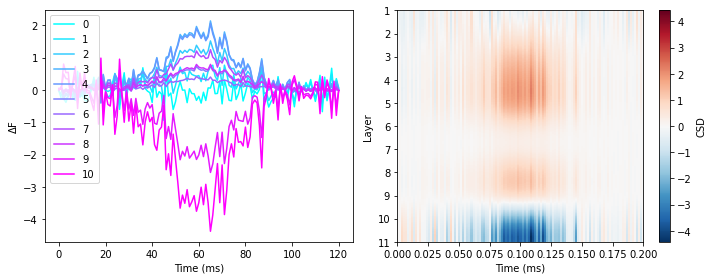

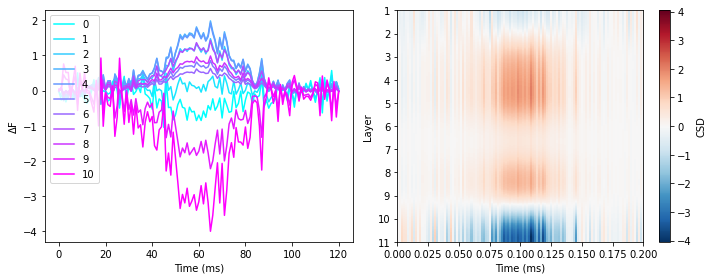

In [12]:
layer_csds=[]
for l in range(n_layers):
    print(f'Simulating in layer {l}')
    prefix=f'sim_{sim_vertex}_{l}.'
    l_vertex=l*int(verts_per_surf)+sim_vertex
    l_sim_fname=run_dipole_simulation(base_fname, prefix, l_vertex, sim_signal, pial_unit_norm, dipole_moment, 
                                      sim_patch_size, SNR)    
    [_,_]=invert_ebb(nas, lpa, rpa, mri_fname, mesh_fname, l_sim_fname, n_layers, patch_size=patch_size, 
                     n_temp_modes=n_temp_modes)
    layer_ts=load_source_time_series(l_sim_fname, vertices=layer_verts)
    layer_ts=np.array(layer_ts)
    csd=csd_calc(layer_ts,np.mean(layer_dists),600)
    smooth_csd=csd_smooth(csd)
    layer_csds.append(smooth_csd)
    
    col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    for l in range(n_layers):
        plt.plot(csd[l,:], label=f'{l}', color=col_r[l,:])
    plt.legend(loc='upper left')
    plt.xlabel('Time (ms)')
    plt.ylabel(r'$\Delta$F')
    ax=plt.subplot(1,2,2)
    plot_csd(smooth_csd, [sim_vertex], bb_path, time, ax)
    plt.xlabel('Time (ms)')
    plt.ylabel('Layer')
    plt.tight_layout()

In [13]:
csd_patterns=[]
for layer_csd in layer_csds:
    t_idx=np.where((time>=0.075) & (time<=0.125))[0]
    csd_patterns.append(np.mean(layer_csd[:,t_idx],axis=1))

Text(0, 0.5, 'Mean CSD')

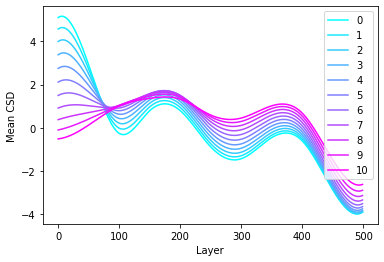

In [15]:
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure()
for l in range(n_layers):
    plt.plot(csd_patterns[l], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper right')
plt.xlabel('Layer')
plt.ylabel('Mean CSD')

In [23]:
deep_width=.025
superficial_width=.01
deep_signal=np.exp(-((time-zero_time)**2)/(2*deep_width**2))
superficial_signal=np.exp(-((time-zero_time)**2)/(2*superficial_width**2))

sim_pos=[white_vertex, pial_vertex]
# Orientation of each dipole
sim_ori=np.vstack([white_unit_norm, pial_unit_norm])
# Dipole momemnts
sim_dipmom=[6, 8] # nAm
# Combined signal
sim_signal=np.vstack([deep_signal, superficial_signal])
# Width of patch
sim_dipfwhm=[5, 5] # mm
    

prefix=f'sim_{sim_vertex}_burst.'
burst_sim_fname=run_dipole_simulation(base_fname, prefix, sim_pos, sim_signal, sim_ori, sim_dipmom, sim_dipfwhm,
                                      SNR)    

Text(0, 0.5, 'Amplitude (nAm)')

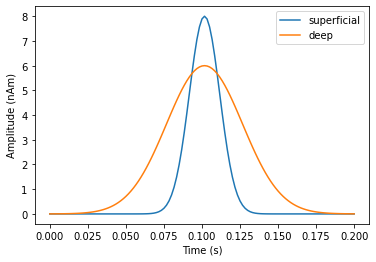

In [24]:
plt.figure()
plt.plot(time,superficial_signal*sim_dipmom[1], label='superficial')
plt.plot(time,deep_signal*sim_dipmom[0], label='deep')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

In [36]:
[_,_]=invert_ebb(nas, lpa, rpa, mri_fname, mesh_fname, burst_sim_fname, n_layers, patch_size=patch_size, 
                 n_temp_modes=n_temp_modes)

Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing


In [37]:
layer_ts=load_source_time_series(burst_sim_fname, vertices=layer_verts)
layer_ts=np.array(layer_ts)
csd=csd_calc(layer_ts,.01,600)
smooth_csd=csd_smooth(csd)

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


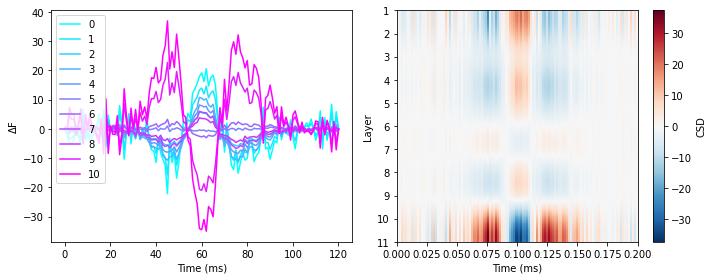

In [38]:
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for l in range(n_layers):
    plt.plot(csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')
ax=plt.subplot(1,2,2)
plot_csd(smooth_csd, [sim_vertex], bb_path, time, ax)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()

In [ ]:
# Delete simulation files

# Iterate over all items in the directory
for item in os.listdir(tmp_dir):
    item_path = os.path.join(tmp_dir, item)

    # Check if it's a file or a directory
    if os.path.isfile(item_path):
        # Delete the file
        os.remove(item_path)
    elif os.path.isdir(item_path):
        # Recursively delete the directory
        shutil.rmtree(item_path)